# I. Problem Formulation

This dataset contains data on the customers of a company in the Payment Processing business. The original dataset has been masked. In addition to basic demographic information of customers, such as state, area, and their processing volumes, this dataset also includes rather or not a particular customer churned, which then will be utilized to develop a Churn Prediction Model.

In [1]:
import os
import time
import copy
import joblib
import pandas as pd
import numpy as np
from numpy.random import seed
from scipy.stats import normaltest
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from scipy.stats import norm
from scipy.stats import shapiro
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
# Initiate the random number generator
seed(1)

# II. Exploratory Data Analysis

## 1. Prepare Data

In [47]:
# Using os library to generate relative path to avoid the problem of OS-specific separator.
wd = os.getcwd()
input_data = os.path.join(wd,'churn_prediction', 'Dataset','data_churn_model.csv')

# Load the dataset 
df = pd.read_csv(input_data, header = 0)

In [48]:
# Create a Faker instance
faker = Faker()

# Function to generate a random company name
def generate_random_company_name():
    return faker.company()

# Create a function to mask the data
def mask_data(original_df, noise_factor):
    # Create a deep copy of the original dataframe to avoid modifying it directly
    masked_df = original_df.copy(deep=True)

    for feature in masked_df.columns:
        if masked_df[feature].dtype == 'float64':
            # Add random noise to numerical features
            noise = np.random.normal(0, noise_factor, len(masked_df))
            masked_df[feature] = masked_df[feature] + noise
        elif feature == 'customer_id':
            # Introduce random variations to customer_id
            masked_df[feature] = masked_df[feature] + np.random.randint(-100, 100, len(masked_df))
        elif feature == 'state_code':
            # Introduce variation in state_code
            state_variants = ['NY', 'IL', 'WA', 'AZ', 'GA']
            masked_df[feature] = np.random.choice(state_variants, len(masked_df))
        elif feature == 'company_name':
            # Generate a new random company name
            masked_df[feature] = [generate_random_company_name() for _ in range(len(masked_df))]
        elif masked_df[feature].dtype == 'object':
            # Introduce variations to categorical features
            unique_values = masked_df[feature].unique()
            masked_df[feature] = np.random.choice(unique_values, len(masked_df))

    return masked_df

# Create a masked version of the dataset
df = mask_data(df, noise_factor=100)

## 2. Descriptive Statistics: Feature Observation & Hypothesis Formulation
- Objective: Understand the data to make informed decisions during the modeling process

### Examine data types, dimensions, and basic statistics

In [49]:
# Take a quick look at the dataset
df.head()

,customer_id,company_name,country,state_code,zip_code,do_not_call,start_date,language,is_referral_participation,referral_role,lifetime_number_of_transactions,lifetime_volume,is_churn
0,58,Baker-Wilson,US,GA,59631,0,1/30/18,spanish,0,both,161,1.061683e+05,1
1,261,Lee and Sons,US,GA,98674,0,12/7/17,spanish,0,referee,782,1.803230e+06,1
2,218,"Henderson, Figueroa and Williamson",US,AZ,72632-3147,0,11/23/20,both,0,referee,735,6.724788e+05,1
3,284,"Santana, Young and Ellis",US,GA,37078,0,8/23/13,english,0,both,2004,5.849025e+06,0
4,299,Parks PLC,US,AZ,55346,0,7/31/19,spanish,0,NaN,139,3.389176e+05,1


In [5]:
# Shape of the dataset
df.shape

(50270, 13)

In [6]:
# Column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50270 entries, 0 to 50269
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   customer_id                      50270 non-null  int64  
 1   company_name                     50270 non-null  object 
 2   country                          50270 non-null  object 
 3   state_code                       50230 non-null  object 
 4   zip_code                         48612 non-null  object 
 5   do_not_call                      50270 non-null  int64  
 6   start_date                       50270 non-null  object 
 7   language                         50270 non-null  object 
 8   is_referral_participation        50270 non-null  int64  
 9   referral_role                    7820 non-null   object 
 10  lifetime_number_of_transactions  50270 non-null  int64  
 11  lifetime_volume                  50270 non-null  float64
 12  is_churn          

In [7]:
# Summary of datatypes
df.dtypes

customer_id                          int64
company_name                        object
country                             object
state_code                          object
zip_code                            object
do_not_call                          int64
start_date                          object
language                            object
is_referral_participation            int64
referral_role                       object
lifetime_number_of_transactions      int64
lifetime_volume                    float64
is_churn                             int64
dtype: object

In [8]:
# Copy the original dataframe into a backup dataframe to be ready for data preprocessing
backup_df = df.copy(deep=True)

In [50]:
# drop uneccessary columns
df.drop(['customer_id', 'company_name'], axis = 1, inplace = True)

In [51]:
# Re-check the dataframe
df.head()

,country,state_code,zip_code,do_not_call,start_date,language,is_referral_participation,referral_role,lifetime_number_of_transactions,lifetime_volume,is_churn
0,US,GA,59631,0,1/30/18,spanish,0,both,161,1.061683e+05,1
1,US,GA,98674,0,12/7/17,spanish,0,referee,782,1.803230e+06,1
2,US,AZ,72632-3147,0,11/23/20,both,0,referee,735,6.724788e+05,1
3,US,GA,37078,0,8/23/13,english,0,both,2004,5.849025e+06,0
4,US,AZ,55346,0,7/31/19,spanish,0,NaN,139,3.389176e+05,1


In [52]:
# summary statistics of the dataset
df.describe()

,do_not_call,is_referral_participation,lifetime_number_of_transactions,lifetime_volume,is_churn
count,50270.000000,50270.000000,50270.000000,5.027000e+04,50270.000000
mean,0.003262,0.155560,390.143943,7.072956e+05,0.594390
std,0.057025,0.362441,670.097180,3.189275e+06,0.491015
min,0.000000,0.000000,1.000000,-1.507727e+03,0.000000
25%,0.000000,0.000000,20.000000,1.224047e+04,0.000000
50%,0.000000,0.000000,148.000000,1.215979e+05,1.000000
75%,0.000000,0.000000,485.000000,5.537873e+05,1.000000
max,1.000000,1.000000,25170.000000,3.675131e+08,1.000000


### Feature Observation & Hypothesis Formulation
- By visualizing distributions, we address several key problems:
    - Separately analyze features  (both numerical and categorical)
        - Check data distribution
        - Identify Null Values & Outliers
    - Explore relationships between input features - input features & input features - output classes
    - Check class imbalance
- Hypotheses will be formulated and tested based on insights we find

#### Separately Analyze Features - Numerical

In [53]:
# Get numerical features excluding binary categorical features

numerical_features = df.loc[:, ((df != 0) & (df != 1)).any()].select_dtypes(exclude=['object']).columns.tolist()

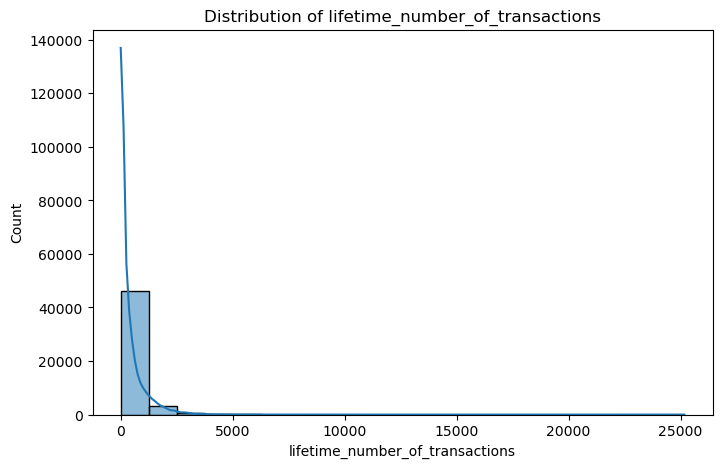

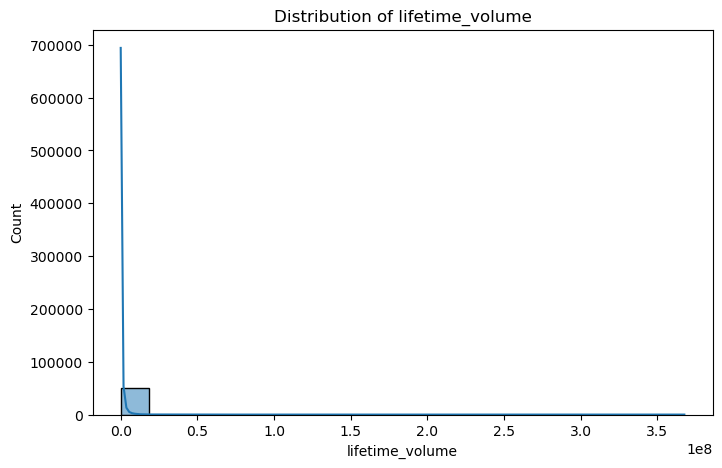

In [54]:
# Data distribution

for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

#### Observation
- The distributions indicate that we have outliers in both lifetime_number_of_transactions & lifetime_volume.

In [55]:
# Calculate the IQR for numerical features
Q1 = df[numerical_features].quantile(0.25)
Q3 = df[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Define a multiplier to determine the threshold for outliers
threshold_multiplier = 1.5

# Identify outliers
outliers = ((df[numerical_features] < (Q1 - threshold_multiplier * IQR)) |
            (df[numerical_features] > (Q3 + threshold_multiplier * IQR)))

# Count and calculate percentage of outliers for each variable
outliers_count = outliers.sum()
outliers_percentage = (outliers_count / len(df)) * 100

# Print the results
for feature in numerical_features:
    print(f"Number of outliers in {feature}: {outliers_count[feature]} ({outliers_percentage[feature]:.2f}%)")


Number of outliers in lifetime_number_of_transactions: 4474 (8.90%)
Number of outliers in lifetime_volume: 6020 (11.98%)


### Observation
- Since outliers only account for small percentage of data, we remove them in the model development phase to improve model accuracy.

In [56]:
# Drop rows containing outliers
df = df[~outliers.any(axis=1)]

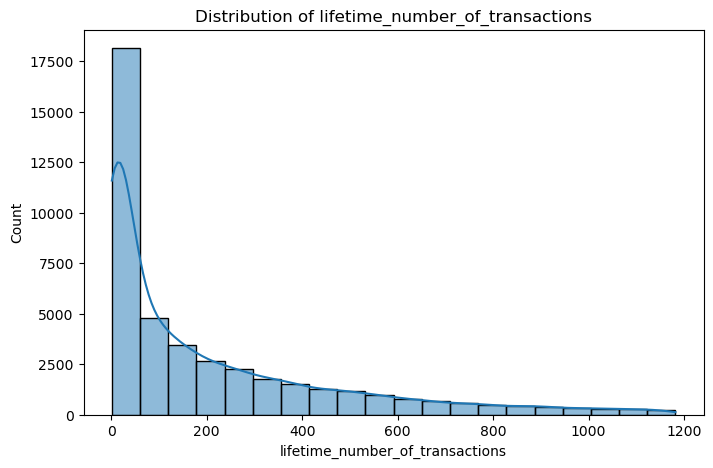

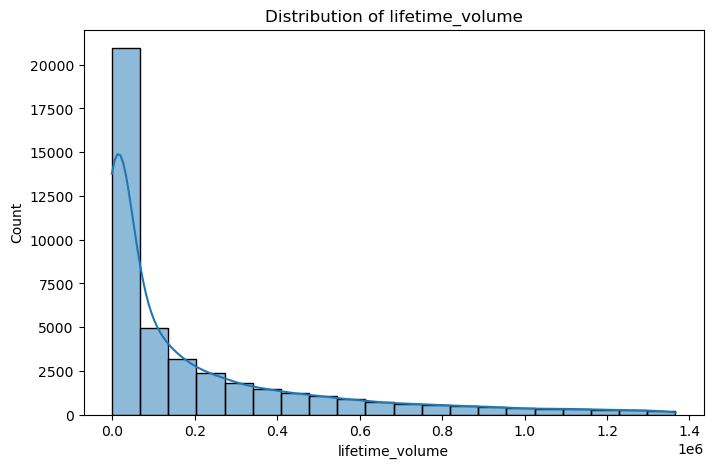

In [57]:
# Distribution without outliers

for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

#### Observation
- Both features seem to follow right skewed distribution
    - When a distribution is right-skewed, it means that the majority of the data points have lower values, and there is a long tail of higher values to the right. In such cases, the mean tends to be greater than the median, and the distribution is not symmetric.
   
- Since the task at hand is classification (predict churn), classification algorithms like Logistic Regression and XGBoost are going to be used. 
    - For classification tasks using models like XGBoost and logistic regression, the assumption of a normal distribution is not a strict requirement. These models are often more robust to non-normal distributions compared to certain parametric models like linear regression
    - Both logistic regression and XGBoost can be sensitive to outliers. Extreme values might influence the decision boundaries or the splits made by the trees. **We will address this problem with log transformation in Data Preprocessing process**

#### Separately Analyze Features - Categorical

In [17]:
# Summary of datatypes
df.dtypes

country                             object
state_code                          object
zip_code                            object
do_not_call                          int64
start_date                          object
language                            object
is_referral_participation            int64
referral_role                       object
lifetime_number_of_transactions      int64
lifetime_volume                    float64
is_churn                             int64
dtype: object

In [18]:
# Get categorical features

categorical_features = df.select_dtypes(include='object').columns.tolist()

print(categorical_features)

['country', 'state_code', 'zip_code', 'start_date', 'language', 'referral_role']


In [19]:
# convert start_date into the correct datatype = datetime
# df['start_date'] = pd.to_datetime(df['start_date']) -> return ParserError

In [20]:
# Explore the data values in start_date since we got ParserError

# Step 1: Check unique values
unique_dates = df['start_date'].unique()
print(unique_dates)


['6/19/13' '6/25/13' '6/26/13' ... '11/22/23' '11/27/23' '11/28/23']


In [21]:
# Step 2: Identify invalid data points

# define date_format
date_format = '%m/%d/%y'

# Identify Invalid Dates:
invalid_dates = df.loc[~pd.to_datetime(df['start_date'], format=date_format, errors='coerce').notnull(), 'start_date']
print(invalid_dates)

2065    0000-00-00
2339    0000-00-00
2362    0000-00-00
2385    0001-01-01
Name: start_date, dtype: object


In [22]:
# Drop invalid data points in start_date

df = df[~df['start_date'].isin(invalid_dates)]

In [23]:
# Convert the 'start_date' column to datetime in the cleaned DataFrame
df['start_date'] = pd.to_datetime(df['start_date'], format=date_format)

In [24]:
# Get categorical features again, after handling date

categorical_features = df.select_dtypes(include='object').columns.tolist()

print(categorical_features)

['country', 'state_code', 'zip_code', 'language', 'referral_role']


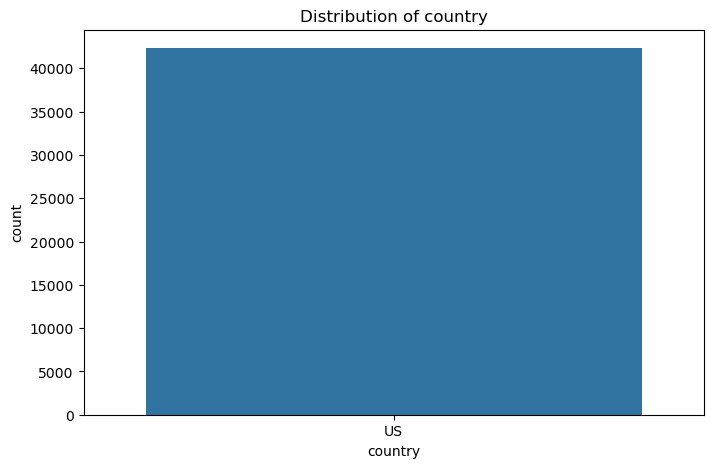

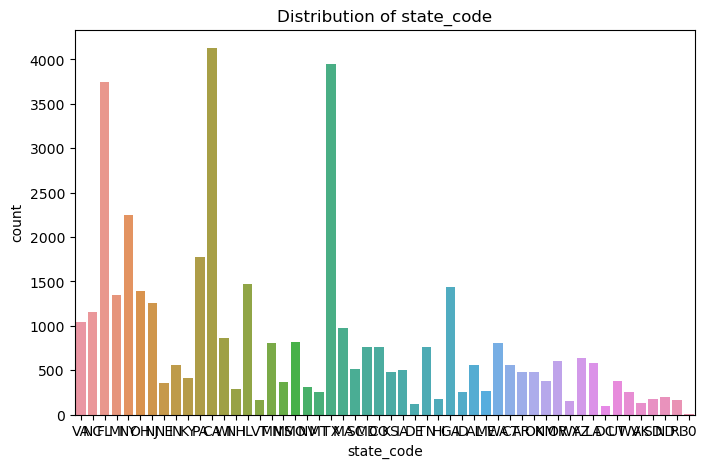

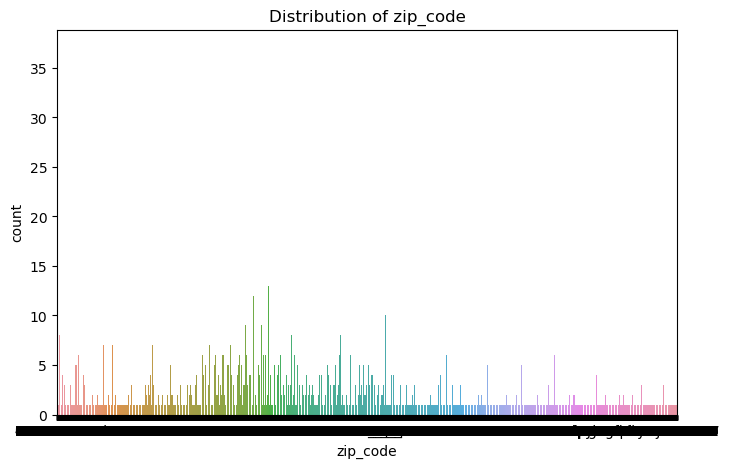

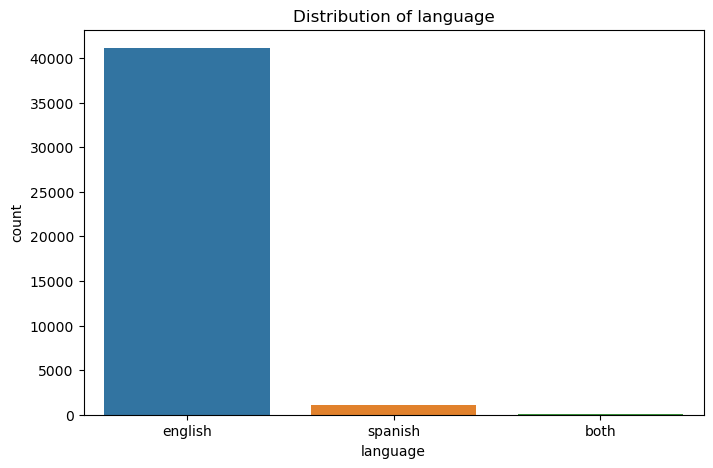

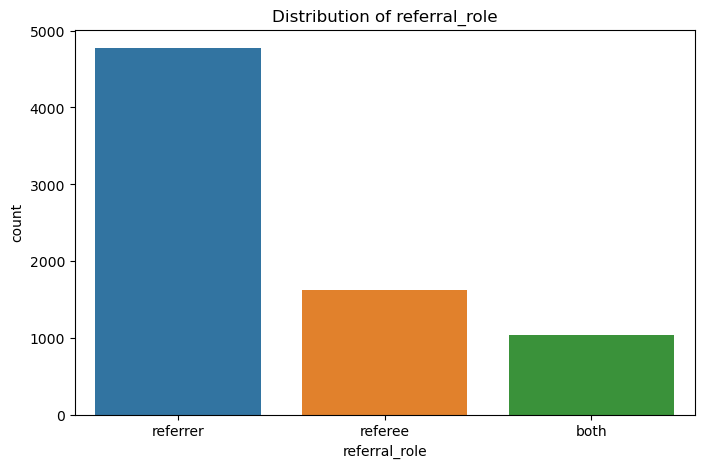

In [25]:
# Distribution of categorical features

for feature in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, data=df)
    plt.title(f'Distribution of {feature}')
    plt.show()

### Observation
1. since most of the data values on country = US, we drop this column since it have no predictive values. This is in fact true because the company serves mostly US customers
2. The distribution of state_code looks multimodal. We'll take a look at 03 modes of the state_code
3. Nothing significant in the distribution of zip_code -> **Exclude this column from the predictive model if it still doesn't have anything significant with regards to is_churn**
4. Most customers speak English only
5. Most customers participate in Referral Program as Referrer

In [58]:
### 1. Drop country
df.drop(['country'], axis=1, inplace=True)

In [59]:
# Get categorical features again, after handling country

categorical_features = df.select_dtypes(include='object').columns.tolist()

In [60]:
# 2. Calculate count and percentage of users for each state_code
state_code_counts = df['state_code'].value_counts().reset_index()
state_code_counts.columns = ['state_code', 'count']

total_users = len(df)
state_code_counts['percentage'] = (state_code_counts['count'] / total_users) * 100

# Sort the dataframe by count in descending order
state_code_counts = state_code_counts.sort_values(by='count', ascending=False)

# Display the results
print("State Code Distribution (Masked data):")
print(state_code_counts)

State Code Distribution (Masked data):
  state_code  count  percentage
0         NY   8549   20.189401
1         WA   8538   20.163423
2         GA   8487   20.042981
3         IL   8459   19.976856
4         AZ   8311   19.627338


#### Observation
- The most amount of customer is living in ...

#### Explore relationships between input features - input features & input features - output classes

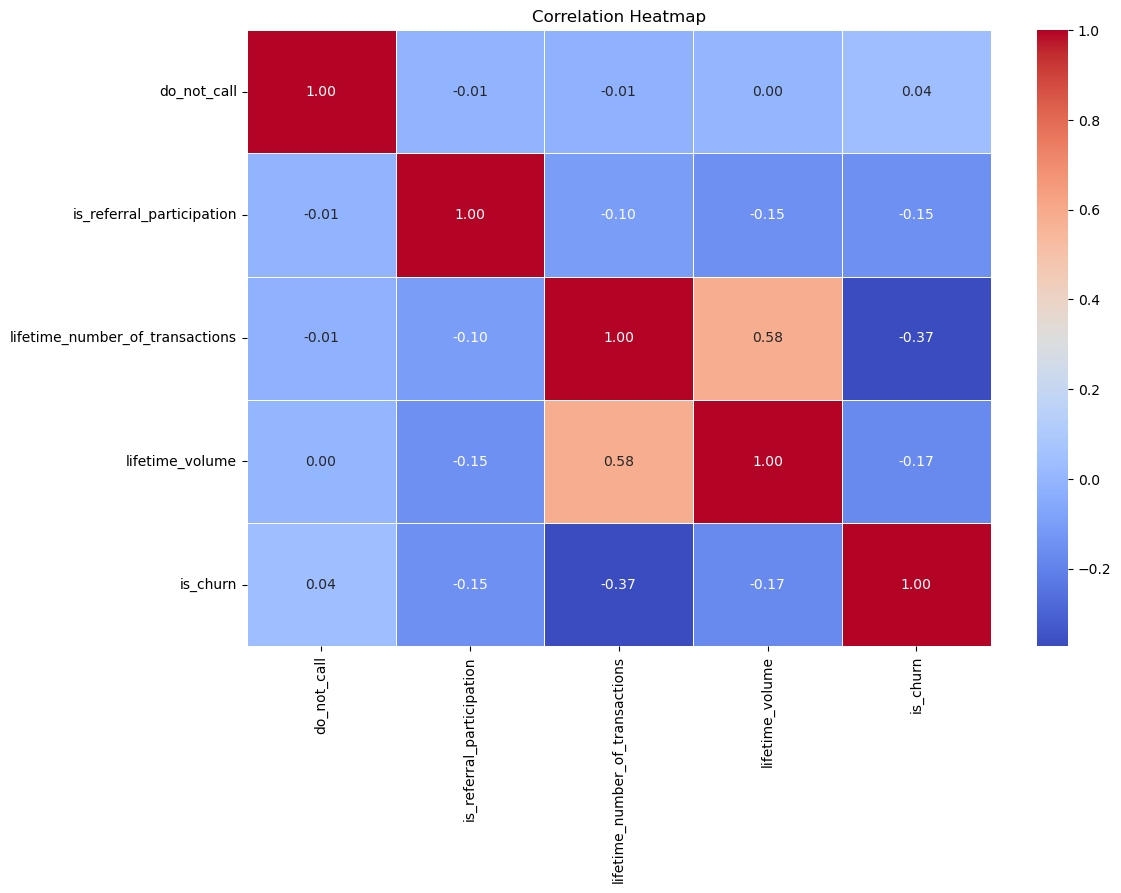

In [29]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

#### Observation
- we can see there are only a medium correlation between lifetime_volume and lifetime_number_of_transaction

#### Decision: Keep both of these attributes

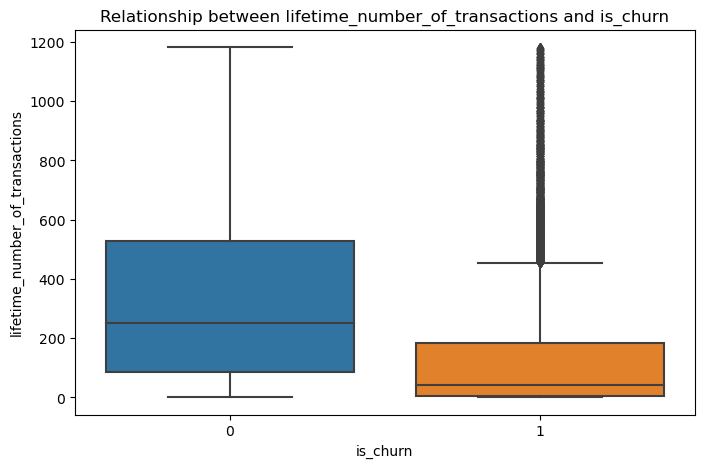

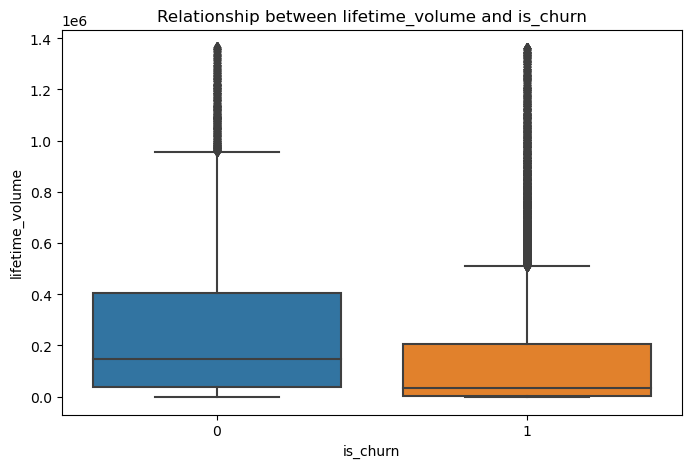

In [30]:
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='is_churn', y=feature, data=df)
    plt.title(f'Relationship between {feature} and is_churn')
    plt.show()

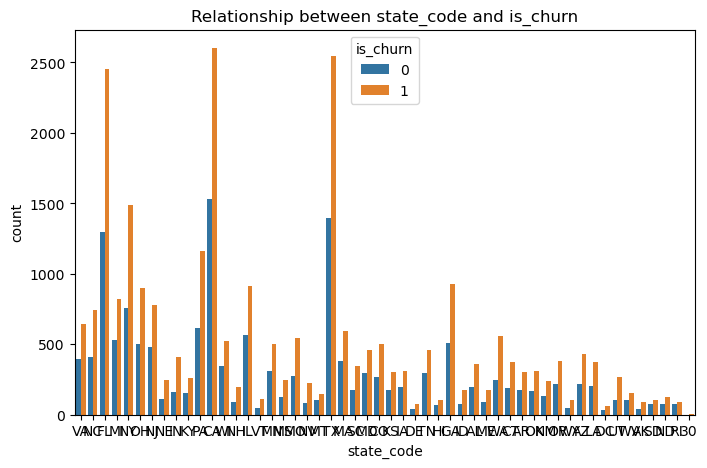

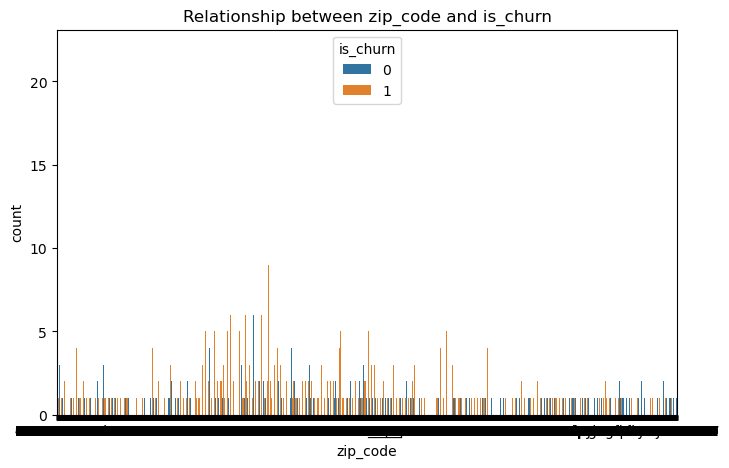

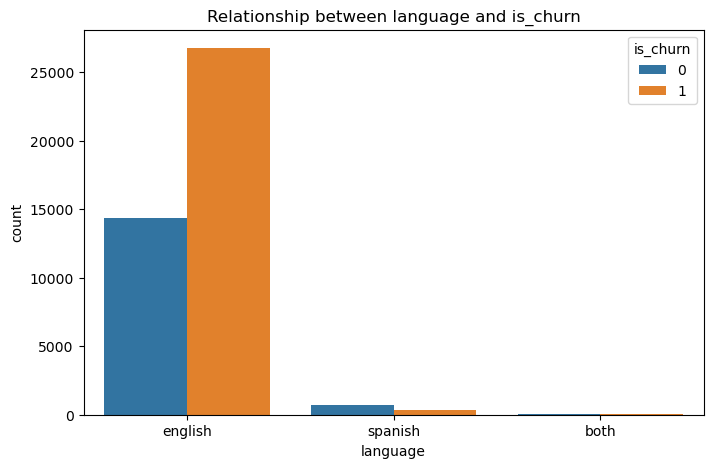

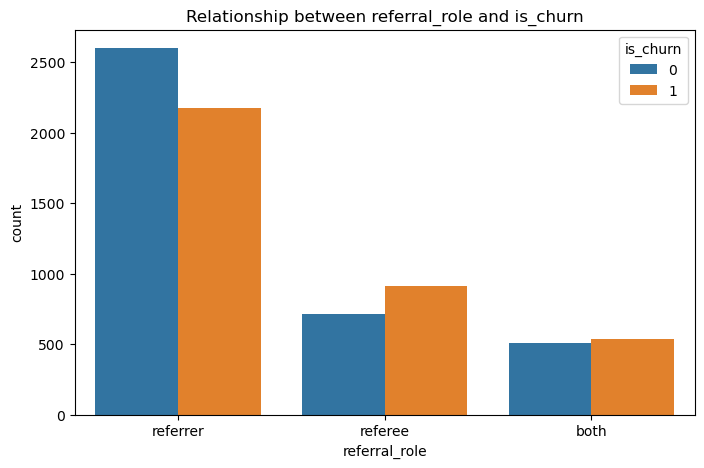

In [31]:
for feature in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, hue='is_churn', data=df)
    plt.title(f'Relationship between {feature} and is_churn')
    plt.show()

#### Observation
- In terms of proportion: 
    - In 03 main states: Churn rates are high
    - English speaking customers has churned more than Spanish speaking customers
    - Referees churned more than Referrers
    
#### Hypothesis
- Percentage wise, Referees churned more than Referrers, so these features (after encoding) would be of great importance

# III. Data Preprocessing

In [32]:
# We check for problems in dataset to make the data ready for model training

### Problem 1: Check Null Values 

In [33]:
null_counts = df.isnull().sum()
total_records = len(df)
null_percentage = (null_counts / total_records) * 100

# Round the percentage to 2 decimals
null_percentage = null_percentage.round(2)

null_summary = pd.DataFrame({
    'column': null_counts.index,
    'number_of_records': total_records,
    'number_of_null': null_counts.values,
    'percentage_of_null': null_percentage.values
})

print(null_summary)

                            column  number_of_records  number_of_null  \
0                       state_code              42339              37   
1                         zip_code              42339            1568   
2                      do_not_call              42339               0   
3                       start_date              42339               0   
4                         language              42339               0   
5        is_referral_participation              42339               0   
6                    referral_role              42339           34896   
7  lifetime_number_of_transactions              42339               0   
8                  lifetime_volume              42339               0   
9                         is_churn              42339               0   

   percentage_of_null  
0                0.09  
1                3.70  
2                0.00  
3                0.00  
4                0.00  
5                0.00  
6               82.42  
7   

In [34]:
# For state_code and zip_code, since the percentages of null are low, we simple drop those records
df = df.dropna(subset=['state_code', 'zip_code'])

In [35]:
# For referral_role with 82.42% null.

## Business Logic: If referral_role is null, it means the customer does not participate in referral program

## First, check for unique value in referral_role
unique_referral_roles = df['referral_role'].unique()

# Display unique values
print(f"Unique Referral Roles: {unique_referral_roles}")

Unique Referral Roles: [nan 'referrer' 'referee' 'both']


In [61]:
## Decision: We impute the null value with "not participated"
df['referral_role'].fillna("not participated", inplace=True)

# Display the DataFrame after imputation
df

,state_code,zip_code,do_not_call,start_date,language,is_referral_participation,referral_role,lifetime_number_of_transactions,lifetime_volume,is_churn
0,GA,59631,0,1/30/18,spanish,0,both,161,106168.298169,1
2,AZ,72632-3147,0,11/23/20,both,0,referee,735,672478.761308,1
4,AZ,55346,0,7/31/19,spanish,0,not participated,139,338917.628561,1
7,IL,80810-5017,0,6/26/15,english,0,referee,178,25596.254091,1
8,AZ,54824-9037,0,6/14/21,english,0,referrer,19,970837.071852,1
...,...,...,...,...,...,...,...,...,...,...
50265,AZ,75602-7196,0,12/23/21,spanish,0,referrer,4,257.831567,0
50266,NY,22718,0,11/14/21,english,1,referee,2,5466.412471,0
50267,IL,55306,0,10/25/22,spanish,0,both,2,6.846566,0
50268,IL,44657,0,10/24/22,both,1,referrer,1,2432.749704,0


In [37]:
##---------------------------------------------------------------------------------------------------------------##

### Problem 2: Check Outliers - Done above



In [38]:
##---------------------------------------------------------------------------------------------------------------##

### Problem 3: Check Rescaling Problem

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40768 entries, 0 to 50269
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   state_code                       40768 non-null  object        
 1   zip_code                         40768 non-null  object        
 2   do_not_call                      40768 non-null  int64         
 3   start_date                       40768 non-null  datetime64[ns]
 4   language                         40768 non-null  object        
 5   is_referral_participation        40768 non-null  int64         
 6   referral_role                    40768 non-null  object        
 7   lifetime_number_of_transactions  40768 non-null  int64         
 8   lifetime_volume                  40768 non-null  float64       
 9   is_churn                         40768 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memo

#### it's best practice to rescale the data to avoid difference in scale problem and help the algorithm to converge faster

In [40]:
# Get numerical columns, EXCEPT binary categorical columns in nature
numerical_features = df.loc[:, ((df != 0) & (df != 1)).any()].select_dtypes(exclude=['object', 'datetime64']).columns.tolist()

# Display the list of numerical features
print("Numerical Features:", numerical_features)

Numerical Features: ['lifetime_number_of_transactions', 'lifetime_volume']


#### Explain code:
- **Step 1**: ((df != 0) & (df != 1)) -> return a df with each element as True/False
- **Step 2**: then .any() is used: (The name .any() in pandas implies "if any element is true.")
    - docs: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.any.html
    - Return Values:
        - if ANY elements in that axis = True -> return True
        - if there's no values, not just one = True (means all is False) -> return False
    - DataFrame.any(*, axis=0, bool_only=False, skipna=True, **kwargs)
    - Default axis = 0 (rows)

In [41]:
## Rescale the numerical features

# Create a StandardScaler instance
scaler = StandardScaler()

# Rescale the selected numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

### Problem 4: Check Multicollinearity

### To solve the problem of Multicollinearity between variables, we use Correlation Heatmap
### Note: Done above

Multicollinearity is a when two or more independent variables in a multiple regression model 
are highly correlated, making it difficult to isolate & explain the individual effect of each variable
on the target variable


### Problem 5: Categorical Variable Encoding

In [42]:
categorical_features = df.select_dtypes(include=['object']).columns
print("Categorical Features:", categorical_features)

# One-hot encode categorical features
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)

Categorical Features: Index(['state_code', 'zip_code', 'language', 'referral_role'], dtype='object')


In [43]:
##---------------------------------------------------------------------------------------------------------------##

### Problem 6: Check Class Imbalance

- check the imbalance in the percentage of each class in target variable

In [44]:
# Calculate value counts for each class
churn_counts = df["is_churn"].value_counts()

# Calculate percentage for each class
churn_percentage = (churn_counts / len(df)) * 100

# Print the results
for label, count, percentage in zip(churn_counts.index, churn_counts, churn_percentage):
    print(f"Class {label}: Count={count}, Percentage={percentage:.2f}%")


Class 1: Count=26186, Percentage=64.23%
Class 0: Count=14582, Percentage=35.77%


#### Observation
- the class distribution in your dataset appears to be imbalanced. The class with "churn" label 1 has 64.23% of the samples, and the class with label 0 has 35.77% of the samples. 
- A balanced dataset is generally desirable for training machine learning models, as it helps prevent the model from being biased toward one class.
- We need to handle class imbalance problem. 
    - 1st solution: We try Ensemble Learning Methods like XGBoost that can handle the problem of Class Imbalance itself
    - If the performance is still bad, we'll use upsampling (we do not use another commonly used method called Down-sampling, to avoid the problem of missing information.

# III. Model Implementation

#### Since the objective is to predict as many customers who actually churn as possible, Recall is selected as Performance metric
- Recall is used when the cost of False Negative is high (in this case: Predict not churn, in fact Churn). We want to capture the actual churn customers as many as possible
- Precision is used when the cost of False Positive is high (in this case: Predict churn, in fact not)

### Observation 
- To avoid the problem of losing classes balance when we split the train & test data, we use the 'stratify' parameter in the train_test_split function. The 'stratify' parameter ensures that the splitting process maintains the proportion of classes in both the training and testing sets.
- Stratify is a sampling method to keep the balance between classes


In [45]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Import the data
wd = os.getcwd()
input_data = os.path.join(wd, 'churn_prediction', 'Dataset', 'data_churn_model.csv')
df = pd.read_csv(input_data, header=0)

# Drop columns 'company_name', 'zip_code', and 'country'
df.drop(['customer_id','company_name', 'zip_code', 'country'], axis=1, inplace=True)

# Impute the null value in referral_role with "not participated"
df['referral_role'].fillna("not participated", inplace=True)

# Get numerical features
numerical_features = df.loc[:, ((df != 0) & (df != 1)).any()].select_dtypes(exclude=['object']).columns.tolist()

# Calculate the IQR for numerical features
Q1 = df[numerical_features].quantile(0.25)
Q3 = df[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Define a multiplier to determine the threshold for outliers (e.g., 1.5)
threshold_multiplier = 1.5

# Identify outliers
outliers = ((df[numerical_features] < (Q1 - threshold_multiplier * IQR)) |
            (df[numerical_features] > (Q3 + threshold_multiplier * IQR)))

# Count and calculate the percentage of outliers for each variable
outliers_count = outliers.sum()
outliers_percentage = (outliers_count / len(df)) * 100

# Drop rows containing outliers
df = df[~outliers.any(axis=1)]

# Get categorical features
categorical_features = df.select_dtypes(include='object').columns.tolist()

# Identify invalid data points
date_format = '%m/%d/%y'
invalid_dates = df.loc[~pd.to_datetime(df['start_date'], format=date_format, errors='coerce').notnull(), 'start_date']

# Drop invalid data points in start_date
df = df[~df['start_date'].isin(invalid_dates)]

# Get categorical features again, after handling date
categorical_features = df.select_dtypes(include='object').columns.tolist()

# One-hot encode categorical features
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)

# Apply log transformation to numerical features to make the distribution normal
for feature in numerical_features:
    df[feature] = np.log1p(df[feature])

# Concatenate numerical and encoded categorical features
X = pd.concat([df[numerical_features], df_encoded], axis=1)
y = df["is_churn"]

# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Use XGBoost for the model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Print the model name
print("XGBoost Model:")

# Calculate and print the recall for Class 1
recall_churn_class = classification_report(y_test, y_pred, target_names=["Not Churn", "Churn"]).split('\n')[3].split()[2]
print(f"Recall for Churn: {recall_churn_class}")
print() #print a blank line
print("Classification Report")
print(classification_report(y_test, y_pred, target_names=["Not Churn", "Churn"]))

XGBoost Model:
Recall for Churn: 0.87

Classification Report
              precision    recall  f1-score   support

   Not Churn       0.69      0.54      0.61      3028
       Churn       0.77      0.87      0.82      5440

    accuracy                           0.75      8468
   macro avg       0.73      0.70      0.71      8468
weighted avg       0.74      0.75      0.74      8468



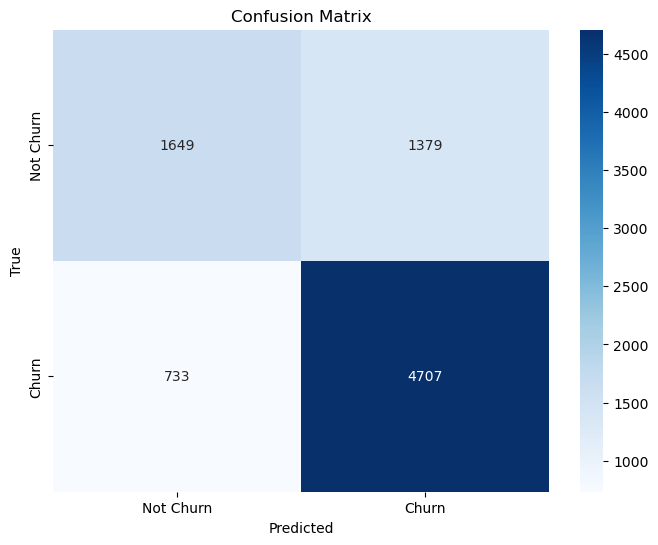

In [46]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()